In [1]:
import copy
import torch
import torch.nn as nn
import numpy as np
import os
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from sklearn import metrics

from flcore.pflniid_utils.data_utils import read_client_data
from utils.custom_loss_class import CPHSLoss
#from flcore.clients.clienbase import Client

import pickle
import matplotlib.pyplot as plt

In [ ]:
#def read_client_data(dataset, idx, is_train=True, condition_number=1, test_split=0.2, test_split_each_update=False):
#    # KAI'S EDITED VERSION WHICH IS NOW USED IN THE CODE
#    print(f"Client{idx}, train={is_train}: read_CLIENT_data() called!")
#    
#    dataset_obj = read_data(dataset, idx, is_train, condition_number=condition_number, test_split=test_split, test_split_each_update=test_split_each_update)
#    X_data = torch.Tensor(dataset_obj['x']).type(torch.float32)
#    y_data = torch.Tensor(dataset_obj['y']).type(torch.float32)
#    zipped_data = [(x, y) for x, y in zip(X_data, y_data)]
#    return zipped_data

In [43]:
zd = read_client_data('cphs', 0)

Client0, train=True: read_CLIENT_data() called!
Client0, train=True: read_data() called!


In [50]:
len(zd)

16616

In [46]:
emg_data = zd[0]
emg_labels = zd[1]

In [47]:
type(emg_data)

tuple

In [48]:
emg_data

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0.]))

In [49]:
len(emg_data)

2

In [51]:
# Unzip
emg_data, emg_labels = list(zip(*zd))

In [52]:
len(emg_data)

16616

In [53]:
emg_data[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Manual Data Split (No Dataloader)

In [2]:
update_ix=[0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]

all_user_keys = ['METACPHS_S106', 'METACPHS_S107', 'METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']
with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block1.pickle", 'rb') as handle:
    refs_block1, _, _, _, emgs_block1, _, _, _, _, _, _ = pickle.load(handle)

idx = 0
condition_number = 0
test_split=0.2
my_user = all_user_keys[idx]
upper_bound = round((1-test_split)*(emgs_block1[my_user][condition_number,:,:].shape[0]))
#return CustomEMGDataset(emgs_block1[my_user][condition_number,:upper_bound,:], refs_block1[my_user][condition_number,:upper_bound,:])

train_emg_c0_cli0 = emgs_block1[my_user][condition_number,:upper_bound,:]
ref_emg_c0_cli0 = refs_block1[my_user][condition_number,:upper_bound,:]

In [3]:
print(emgs_block1[my_user][condition_number,:,:].shape[0])

20770


In [4]:
print(upper_bound)

16616


In [5]:
print(train_emg_c0_cli0.shape)
print()
print(train_emg_c0_cli0)

(16616, 64)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [33.86026003 35.25307787 13.02375661 ...  4.80226271 12.93678155
   9.29002013]
 [33.86026003 35.25307787 13.02375661 ...  4.80226271 12.93678155
   9.29002013]
 [33.86026003 35.25307787 13.02375661 ...  4.80226271 12.93678155
   9.29002013]]


In [6]:
print(ref_emg_c0_cli0.shape)
print()
print(ref_emg_c0_cli0)

(16616, 2)

[[-8.57531218e-05 -5.68816068e-04]
 [-8.57531218e-05 -5.68816068e-04]
 [-2.01000378e-04 -1.32411493e-03]
 ...
 [ 2.18631066e+01 -1.77762132e+01]
 [ 2.18631066e+01 -1.77762132e+01]
 [ 2.24220511e+01 -1.73817723e+01]]


# Toy Example of DataLoader
- https://www.youtube.com/watch?v=3GVUzwXXihs
- https://pytorch.org/docs/stable/_modules/torch/utils/data/sampler.html#BatchSampler

In [7]:
tp = torch.zeros((10,11))
tp[:,0] = torch.arange(10)
tp

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [8., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [8]:
dl = DataLoader(
    dataset=tp,
    batch_size=10, 
    drop_last=False) 

it = iter(dl)

In [9]:
it.__next__()

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [8., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Validating read_client_data()

In [10]:
train_data = read_client_data('cphs', 0, is_train=True)


Client0, train=True: read_CLIENT_data() called!
Client0, train=True: read_data() called!


In [11]:
dl1 = DataLoader(
                dataset=train_data,
                batch_sampler=torch.utils.data.BatchSampler(
                    torch.utils.data.SequentialSampler(train_data), 
                    batch_size=1200, 
                    drop_last=False), 
                shuffle=False
        )
it1 = iter(dl1)

dl2 = DataLoader(
                dataset=train_data,
                batch_size=1200,
                drop_last=False,
                shuffle=False) 
it2 = iter(dl2)


In [12]:
for i, (x, y) in enumerate(dl1):
    print(f"Pair {i} in dl1: x.size(): {x.size()}")

Pair 0 in dl1: x.size(): torch.Size([1200, 64])
Pair 1 in dl1: x.size(): torch.Size([1200, 64])
Pair 2 in dl1: x.size(): torch.Size([1200, 64])
Pair 3 in dl1: x.size(): torch.Size([1200, 64])
Pair 4 in dl1: x.size(): torch.Size([1200, 64])
Pair 5 in dl1: x.size(): torch.Size([1200, 64])
Pair 6 in dl1: x.size(): torch.Size([1200, 64])
Pair 7 in dl1: x.size(): torch.Size([1200, 64])
Pair 8 in dl1: x.size(): torch.Size([1200, 64])
Pair 9 in dl1: x.size(): torch.Size([1200, 64])
Pair 10 in dl1: x.size(): torch.Size([1200, 64])
Pair 11 in dl1: x.size(): torch.Size([1200, 64])
Pair 12 in dl1: x.size(): torch.Size([1200, 64])
Pair 13 in dl1: x.size(): torch.Size([1016, 64])


In [13]:
for i, (x, y) in enumerate(dl2):
    print(f"Pair {i} in dl2: x.size(): {x.size()}")

Pair 0 in dl2: x.size(): torch.Size([1200, 64])
Pair 1 in dl2: x.size(): torch.Size([1200, 64])
Pair 2 in dl2: x.size(): torch.Size([1200, 64])
Pair 3 in dl2: x.size(): torch.Size([1200, 64])
Pair 4 in dl2: x.size(): torch.Size([1200, 64])
Pair 5 in dl2: x.size(): torch.Size([1200, 64])
Pair 6 in dl2: x.size(): torch.Size([1200, 64])
Pair 7 in dl2: x.size(): torch.Size([1200, 64])
Pair 8 in dl2: x.size(): torch.Size([1200, 64])
Pair 9 in dl2: x.size(): torch.Size([1200, 64])
Pair 10 in dl2: x.size(): torch.Size([1200, 64])
Pair 11 in dl2: x.size(): torch.Size([1200, 64])
Pair 12 in dl2: x.size(): torch.Size([1200, 64])
Pair 13 in dl2: x.size(): torch.Size([1016, 64])


In [14]:
s1 = it1.__next__()
s2 = it2.__next__()
print(torch.sum(s1[0] - s2[0]))
print()
s1 = it1.__next__()
s2 = it2.__next__()
print(torch.sum(s1[0] - s2[0]))
print()
s1 = it1.__next__()
s2 = it2.__next__()
print(torch.sum(s1[0] - s2[0]))
#print()

tensor(0.)

tensor(0.)

tensor(0.)


In [15]:
#def _train(self):
#    trainloader = self.load_train_data()
#    self.model.train()
#
#    start_time = time.time()
#
#    max_local_steps = self.local_epochs
#
#    for step in range(max_local_steps):
#        for i, (x, y) in enumerate(trainloader):
#            print(f"Step {step}, pair {i} in traindl")
#            print(f"x.size(): {x.size()}")
#            if type(x) == type([]):
#                x[0] = x[0].to(self.device)
#            else:
#                x = x.to(self.device)
#            y = y.to(self.device)
#            output = self.model(x)
#            loss = self.loss(output, y, self.model)
#            self.optimizer.zero_grad()
#            loss.backward()
#            self.optimizer.step()

In [16]:
def simulate_data_streaming(dl, model, my_pca_channels=64, dt=1/60):
    it = iter(dl)
    s0 = it.__next__()
    s_temp = s0[0][:1200,:]
    p_reference = torch.transpose(s0[1][:1200,:], 0, 1)

    # First, normalize the entire s matrix
    if False:
        s_normed = s_temp / torch.linalg.norm(s_temp, ord='fro')
        assert (torch.linalg.norm(s_normed, ord='fro')<1.2) and (torch.linalg.norm(s_normed, ord='fro')>0.8)
    else:
        s_normed = s_temp
    # Apply PCA if applicable
    if my_pca_channels!=64:  # 64 is the number of channels present on the recording armband
        pca = PCA(n_components=my_pca_channels)
        s = torch.transpose(torch.tensor(pca.fit_transform(s_normed), dtype=torch.float32), 0, 1)
    else:
        s = torch.transpose(s_normed, 0, 1)

    F = s[:,:-1]
    v_actual =  torch.matmul(model.weight, s)
    p_actual = torch.cumsum(v_actual, dim=1)*dt  # Numerical integration of v_actual to get p_actual
    V = (p_reference - p_actual)*dt
    if False:
        pass
        #self.V = self.V/torch.linalg.norm(self.V, ord='fro')
        #assert (torch.linalg.norm(self.V, ord='fro')<1.2) and (torch.linalg.norm(self.V, ord='fro')>0.8)
    Y = p_reference[:, :-1]  # To match the input
    return F, V, Y

In [17]:
init_dl = dl2
model = torch.nn.Linear(64, 2)
F, V, Y = simulate_data_streaming(dl2, model)

loss = CPHSLoss(F, model.weight, V, F.size()[1])

optimizer = torch.optim.SGD(model.parameters(), lr=0.005)  #self.learning_rate)
#learning_rate_scheduler = torch.optim.lr_scheduler.ExponentialLR(
#    optimizer=self.optimizer, 
#    gamma=args.learning_rate_decay_gamma
#)
#self.learning_rate_decay = args.learning_rate_decay

In [39]:
#training_iterator = iter(dl2)
#s = training_iterator.__next__()

trainloader = dl2  #self.load_train_data()
# No idea what model.train() does
model.train()

#start_time = time.time()

max_local_steps = 1  #self.local_epochs
loss_log = []
for step in range(max_local_steps):
    for i, (x, y) in enumerate(trainloader):
        print(f"Step {step}, pair {i} in traindl")
        print(f"x.size(): {x.size()}")
        output = model(x)
        current_loss = loss(output, y, model)
        loss_log.append(current_loss.detach().numpy())
        optimizer.zero_grad()
        current_loss.backward()
        optimizer.step()
        print()

Step 0, pair 0 in traindl
x.size(): torch.Size([1200, 64])
Error term: 0.12047553062438965
D term: 0.0004961676895618439
F term: 0

Step 0, pair 1 in traindl
x.size(): torch.Size([1200, 64])
Error term: 0.11298820376396179
D term: 0.0004940247163176537
F term: 0

Step 0, pair 2 in traindl
x.size(): torch.Size([1200, 64])
Error term: 0.19714921712875366
D term: 0.000493132509291172
F term: 0

Step 0, pair 3 in traindl
x.size(): torch.Size([1200, 64])
Error term: 0.056870270520448685
D term: 0.0004903310327790678
F term: 0

Step 0, pair 4 in traindl
x.size(): torch.Size([1200, 64])
Error term: 0.09256390482187271
D term: 0.0004892811994068325
F term: 0

Step 0, pair 5 in traindl
x.size(): torch.Size([1200, 64])
Error term: 0.12735620141029358
D term: 0.0004877150058746338
F term: 0

Step 0, pair 6 in traindl
x.size(): torch.Size([1200, 64])
Error term: 0.0349312424659729
D term: 0.000485733529785648
F term: 0

Step 0, pair 7 in traindl
x.size(): torch.Size([1200, 64])
Error term: 0.05003

In [40]:
1200*13+1016

16616

Idk... 16616 is the upper limit of the training split.  Should I make all of the updates the same size? By using the actual update size or making new updates? Probably want to use the actual updates...

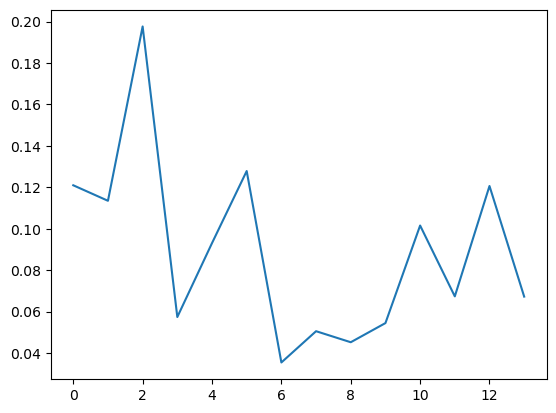

In [41]:
plt.plot(loss_log)

# Deconstructed load_train_data() From Clientbase.py

In [19]:
#self.model = copy.deepcopy(args.model)
algorithm = 'FedAvg'
dataset = 'cphs'
device = 'cpu'
ID = 0  # integer
#self.save_folder_name = args.save_folder_name

#self.num_classes = args.num_classes
#train_samples = train_samples
#test_samples = test_samples
batch_size = 1200
learning_rate = 0.005
local_epochs = 1

# My additional parameters
pca_channels = 64
lambdas = [0, 1e-3, 1e-4]
lambdaF = lambdas[0]
lambdaD = lambdas[1]
lambdaE = lambdas[2]
current_update = 0
local_round = 0
last_global_round = 0
local_round_threshold = 50
update_ix=[0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]

In [20]:
local_round += 1
if local_round%local_round_threshold==0:
    current_update += 1

if batch_size == None:
    batch_size = batch_size
train_data = read_client_data(dataset, ID, is_train=True)


Client0, train=True: read_CLIENT_data() called!
Client0, train=True: read_data() called!


In [21]:
loader = DataLoader(
        dataset=train_data,
        batch_sampler=torch.utils.data.BatchSampler(
            torch.utils.data.SequentialSampler(dataset), 
            batch_size=batch_size, 
            drop_last=False) 
)
sit1 = iter(loader)
s1 = sit1.__next__()
print(s1[0].size())
print(s1[0][:, :10])

torch.Size([4, 64])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [16.4556, 18.0038,  2.8854,  5.8259,  8.1008,  2.2209,  9.7316, 19.7165,
         11.9520,  0.5433]])


In [22]:
# I think it is doing Sequential Sampler by default, if shuffle is False (which is true by default)

loader2 = DataLoader(
        dataset=train_data,
        batch_size=batch_size, 
        drop_last=False) 
sit2 = iter(loader2)
s2 = sit2.__next__()
print(s2[0].size())
print(s2[0][:4, :10])

torch.Size([1200, 64])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [16.4556, 18.0038,  2.8854,  5.8259,  8.1008,  2.2209,  9.7316, 19.7165,
         11.9520,  0.5433]])


In [23]:
print(s2[0][:10, :5])

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [16.4556, 18.0038,  2.8854,  5.8259,  8.1008],
        [16.4556, 18.0038,  2.8854,  5.8259,  8.1008],
        [16.4556, 18.0038,  2.8854,  5.8259,  8.1008],
        [40.5837, 41.7818, 13.8757, 12.2603, 15.2425],
        [58.4589, 56.5549, 24.6047, 24.2789, 20.7511],
        [58.4589, 56.5549, 24.6047, 24.2789, 20.7511],
        [45.4502, 43.0116, 24.5893, 24.8776, 16.5744]])


In [24]:
print(f"s2 type: {type(s2)}")
print(f"s2 len: {len(s2)}")
print(f"s2[0] (training data) size: {s2[0].size()}")
print(f"s2[1] (training data) size: {s2[1].size()}")

s2 type: <class 'list'>
s2 len: 2
s2[0] (training data) size: torch.Size([1200, 64])
s2[1] (training data) size: torch.Size([1200, 2])


In [25]:
s2[0]

tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [128.8972,  71.8650,  34.2512,  ...,   8.3115,  10.0432,   9.2224],
        [135.5390,  80.6596,  33.9306,  ...,  10.5396,  11.5099,   9.2469],
        [135.5390,  80.6596,  33.9306,  ...,  10.5396,  11.5099,   9.2469]])

## Integrating With CPHS Processing Code

In [26]:
s_temp = s2[0][0:update_ix[1]]

In [27]:
normalize_EMG = False
PCA_comps = 64

# First, normalize the entire s matrix
if normalize_EMG:
    s_normed = s_temp/torch.max(s_temp)
else:
    s_normed = s_temp
# Now do PCA unless it is set to 64 (AKA the default num channels i.e. no reduction)
# Also probably ought to find a global transform if possible so I don't recompute it every time...
if PCA_comps!=64:  
    pca = PCA(n_components=PCA_comps)
    s_normed = pca.fit_transform(s_normed)
#s = np.transpose(s_normed)

In [28]:
s_normed.size()

torch.Size([1200, 64])

In [29]:
s = torch.transpose(s_normed, 0, 1)
s.size()

torch.Size([64, 1200])

In [30]:
# Can't run this since I don't have the model weights

#F = s[:,:-1] # note: truncate F for estimate_decoder
#v_actual = self.w@s
#p_actual = np.cumsum(v_actual, axis=1)*self.dt  # Numerical integration of v_actual to get p_actual
#p_reference = np.transpose(self.labels[lower_bound:upper_bound,:])
#self.V = (p_reference - p_actual)*self.dt
#
#self.loss = CPHSLoss(self.F, self.model.weight, self.V, torch.view(self.F)[0], lambdaF=self.lambdaF, lambdaD=self.lambdaD, lambdaE=self.lambdaE, Nd=2, Ne=self.pca_channels, return_cost_func_comps=False)
#
#self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
#self.learning_rate_scheduler = torch.optim.lr_scheduler.ExponentialLR(
#    optimizer=self.optimizer, 
#    gamma=args.learning_rate_decay_gamma
#)
#self.learning_rate_decay = args.learning_rate_decay

## Checking How Many Iterations The Iter Object Has

In [31]:
try:
    s2 = sit2.__next__()
    print("We can run multiple times!")
except StopIteration:
    print("StopIteration Error: Can only call next once!")

We can run multiple times!


Why can we run multiple times... can we run 18 or 19 total times (once for each update?)?

In [32]:
for i in range(19):
    try:
        s2 = sit2.__next__()
        print(i+2)  # +2 since we have already called __next__() twice in the code above
    except StopIteration:
        print("StopIteration Error: Can only call next once!")

2
3
4
5
6
7
8
9
10
11
12
13
StopIteration Error: Can only call next once!
StopIteration Error: Can only call next once!
StopIteration Error: Can only call next once!
StopIteration Error: Can only call next once!
StopIteration Error: Can only call next once!
StopIteration Error: Can only call next once!
StopIteration Error: Can only call next once!
